In [13]:
#!pip3 install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip


In [15]:
#!pip3 install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 926.4 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 2.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  DEPRECATION: kaggle is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for kaggle ... done

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip


In [73]:

import numpy as np #Linear Algebra 
import pandas as pd #Data Analysis 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


from sklearn import svm #Classification / Regression Identification tasks
from sklearn.metrics import accuracy_score #Calculates accuracy score 
from sklearn.preprocessing import StandardScaler#Estimates Empirical Mean & standard deviation
from sklearn.model_selection import train_test_split #Takes separate datasets for training & testing purposes respectively
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')


# About Files

 train_peptides.csv Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.

1. visit_id - ID code for the visit.
1. visit_month - The month of the visit, relative to the first visit by the patient.
1. patient_id - An ID code for the patient.
1. UniProt - The UniProt ID code for the associated protein. There are often several peptides per protein.
1. Peptide - The sequence of amino acids included in the peptide. See this table for the relevant codes. Some rare annotations may not be included in the table. The test set may include peptides not found in the train set.
1. PeptideAbundance - The frequency of the amino acid in the sample.


train_proteins.csv Protein expression frequencies aggregated from the peptide level data.

1. visit_id - ID code for the visit.
1. visit_month - The month of the visit, relative to the first visit by the patient.
1. patient_id - An ID code for the patient.
1. UniProt - The UniProt ID code for the associated protein. There are often several peptides per protein. The test set may include proteins not found in the train set.
1. NPX - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.

train_clinical_data.csv

1. visit_id - ID code for the visit.
1. visit_month - The month of the visit, relative to the first visit by the patient.
1. patient_id - An ID code for the patient. 
1. updrs_[1-4] - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.
1. upd23b_clinical_state_on_medication - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.
1. supplemental_clinical_data.csv Clinical records without any associated CSF samples. This data is intended to provide additional context about the typical progression of Parkinsons. Uses the same columns as train_clinical_data.csv.

example_test_files/ Data intended to illustrate how the API functions. Includes the same columns delivered by the API (ie no updrs columns).

amp_pd_peptide/ Files that enable the API. Expect the API to deliver all of the data (less than 1,000 additional patients) in under five minutes and to reserve less than 0.5 GB of memory. A brief demonstration of what the API delivers is available here.

public_timeseries_testing_util.py An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details.


# Reading Files

In [25]:
proteins_data = pd.read_csv("train_proteins.csv")
peptides_data = pd.read_csv("train_peptides.csv")
clinical_data = pd.read_csv("train_clinical_data.csv")
clinical_sup_data = pd.read_csv("supplemental_clinical_data.csv")

In [5]:
print(df_train_clin.shape)
print(df_train_pept.shape)
print(df_train_prot.shape)

(2615, 8)
(981834, 6)
(232741, 5)


In [26]:
#We will start with the Clinical Data
clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [30]:
#dataset shape
print('proteins shape:\t\t', proteins_data.shape)
print('peptides shape:\t\t', peptides_data.shape)
print('clinical shape:\t\t', clinical_data.shape)
print('sup clinical shape:\t', clinical_sup_data.shape)

proteins shape:		 (232741, 5)
peptides shape:		 (981834, 6)
clinical shape:		 (2615, 8)
sup clinical shape:	 (2223, 8)


In [36]:
#Finding Num of Unique Entries In Each Data Set
print("Unique patient_ids in clinical_data :", len(clinical_data["patient_id"].unique()))
print("Unique visit_ids in testing clinical_data :", len(clinical_data["visit_id"].unique()))
print("Unique visit_months in clinical_data:", len(clinical_data["visit_month"].unique()))


Unique patient_ids in clinical_data : 248
Unique visit_ids in testing clinical_data : 2615
Unique visit_months in clinical_data: 17


In [34]:
print("Unique patient_ids in clinical_sup :", len(clinical_sup_data["patient_id"].unique()))
print("Unique visit_ids in clinical_sup :", len(clinical_sup_data["visit_id"].unique()))
print("Unique visit_months in clinical_sup :", len(clinical_data["visit_month"].unique()))


Unique patient_ids in clinical_sup : 771
Unique visit_ids in clinical_sup : 2223
Unique visit_months in clinical_sup : 17


In [37]:
print("Unique patient_ids in proteins_data :", len(proteins_data["patient_id"].unique()))
print("Unique visit_ids in proteins_data :", len(proteins_data["visit_id"].unique()))
print("Unique visit_months in proteins_data :", len(proteins_data["visit_month"].unique()))
print("Unique UniProt in proteins_data :", len(proteins_data["UniProt"].unique()))
print("Unique NPX in proteins_data :", len(proteins_data["NPX"].unique()))

Unique patient_ids in proteins_data : 248
Unique visit_ids in proteins_data : 1113
Unique visit_months in proteins_data : 15
Unique UniProt in proteins_data : 227
Unique NPX in proteins_data : 218795


# Data Merging


In [39]:
#Dropping redundant information in the Protein set.
proteins_merge = proteins_data.pivot(index=['visit_id', 'visit_month', 'patient_id'], 
          columns='UniProt',
          values='NPX').reset_index().rename_axis(None, axis=1)

proteins_merge.head()

,visit_id,visit_month,patient_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,10053_0,0,10053,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
1,10053_12,12,10053,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
2,10053_18,18,10053,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
3,10138_12,12,10138,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,...,557904.0,44556.90,155619.0,14647.9,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
4,10138_24,24,10138,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,...,NaN,47836.70,177619.0,17061.1,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55


In [40]:
#We want to drop NaN values, as they may interfere with our results.
proteins = proteins_merge.dropna(axis=1).drop(columns=['visit_month', 'patient_id'])
proteins.head()

,visit_id,O15240,P01009,P01011,P01023,P01024,P01042,P01834,P01876,P02647,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,10053_0,83002.9,12825300.0,1084770.0,1005230.0,2669740.0,541909.0,2440800.0,1874270.0,4032650.0,...,3858400.0,4087060.0,1352720.0,731854.0,4749780.0,822784.0,42511700.0,1051980.0,322496.0,177983.0
1,10053_12,197117.0,11871200.0,1135570.0,1230990.0,3360790.0,584371.0,2030500.0,1800070.0,5111760.0,...,3708010.0,3491420.0,1390950.0,618772.0,4223100.0,661058.0,34100500.0,738247.0,496976.0,171733.0
2,10053_18,126506.0,14319900.0,1444430.0,1333940.0,3728860.0,971184.0,2106740.0,1508300.0,5713180.0,...,4773570.0,5096710.0,2232400.0,879126.0,5728010.0,971421.0,38324600.0,843926.0,674551.0,245188.0
3,10138_12,156313.0,11024900.0,1725440.0,1302590.0,4276570.0,1627070.0,4071840.0,5456100.0,22825800.0,...,6629400.0,5233080.0,2535650.0,1204390.0,7528540.0,1246230.0,34148900.0,816347.0,601869.0,229232.0
4,10138_24,151169.0,14145200.0,1544440.0,1221060.0,4570310.0,1301680.0,2421520.0,3032880.0,11136600.0,...,2628690.0,3852520.0,2443370.0,459165.0,8704760.0,1274950.0,45982800.0,598882.0,569973.0,176722.0


In [45]:
#The product of the proteins and Clinical dataset.
#Placed on the right of Visit_id so not to interfere with important protein information.

merged_df_data = clinical_data.merge(proteins, how='left', on='visit_id').dropna(subset=['O15240'])
print("Size of New Dataframe: ",merged_df_data.shape)
merged_df_data.head()

Size of New Dataframe:  (1068, 35)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O15240,P01009,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,177775.0,14415900.0,...,4774060.0,9137820.0,2607410.0,1401860.0,11575700.0,1673460.0,33921600.0,1611130.0,982965.0,408698.0
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,165638.0,13330800.0,...,5627420.0,8411730.0,2183310.0,1321860.0,10062500.0,1644680.0,34435000.0,1483200.0,860236.0,369870.0
4,55_12,55,12,10.0,10.0,41.0,0.0,On,151073.0,13225500.0,...,5953560.0,8682640.0,2792590.0,1496970.0,10753700.0,1916350.0,37906600.0,1547140.0,969345.0,318553.0
8,55_36,55,36,17.0,18.0,51.0,0.0,On,101056.0,13855000.0,...,6672980.0,9146830.0,2871610.0,1424390.0,11943000.0,1879000.0,32773700.0,1725030.0,910437.0,377550.0
15,942_6,942,6,8.0,2.0,21.0,NaN,NaN,160526.0,13667800.0,...,5755200.0,5415620.0,1636600.0,1090240.0,6855660.0,1085970.0,26674400.0,637932.0,639154.0,306621.0


# Data Visualization

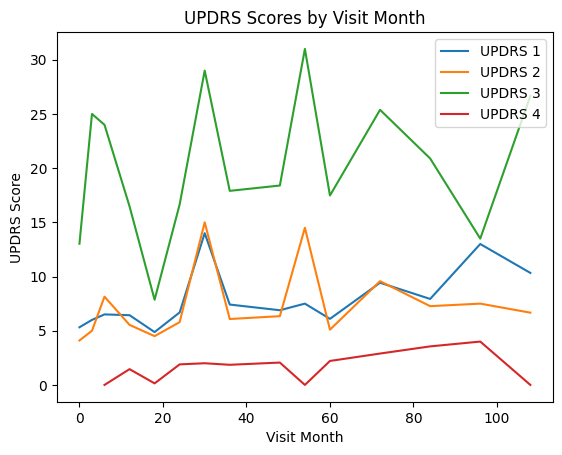

In [46]:
# Create a figure with one subplot.
fig, ax = plt.subplots()

# Calculate their mean values, then store the result in new dataframes.
merged_updrs_1 = merged_df_data.groupby('visit_month')['updrs_1'].mean().reset_index()
merged_updrs_2 = merged_df_data.groupby('visit_month')['updrs_2'].mean().reset_index()
merged_updrs_3 = merged_df_data.groupby('visit_month')['updrs_3'].mean().reset_index()
merged_updrs_4 = merged_df_data.groupby('visit_month')['updrs_4'].mean().reset_index()

# Plot the data as a line plot.
ax.plot(merged_updrs_1['visit_month'], merged_updrs_1['updrs_1'], label = 'UPDRS 1')
ax.plot(merged_updrs_2['visit_month'], merged_updrs_2['updrs_2'], label = 'UPDRS 2')
ax.plot(merged_updrs_3['visit_month'], merged_updrs_3['updrs_3'], label = 'UPDRS 3')
ax.plot(merged_updrs_4['visit_month'], merged_updrs_4['updrs_4'], label = 'UPDRS 4')

# Add a title and axis labels.
ax.set_title('UPDRS Scores by Visit Month')
ax.set_xlabel('Visit Month')
ax.set_ylabel('UPDRS Score')

# Add a legend.
ax.legend()

# Show the plot.
plt.show()

# Evaluation 
The problem is predicting updrs_1, updrs_2, updrs_3 and updrs_4 values at a given visit_month and potential 6, 12 and 24 month visits after the current visit_month.

Predictions are evaluated on symmetric mean absolute percentage error (SMAPE) + 1.

# What is SMAPE?
According to Anaplan...
(https://help.anaplan.com/685ff9b2-6370-46ba-af10-679405937113-Understand-advanced-metrics)

SMAPE (symmetric mean absolute percentage error) is an accuracy measure based on percentage (or relative) errors. 

SMAPE has both a lower bound and an upper bound. Since it's percentage-based, it's scale-independent, which means that it can be used to compare forecast performances between datasets. 

In [89]:
def smape(y_true, y_pred):
    """
    Parameters
    ----------
    y_true: array-like of shape (n_samples)
        Array of ground-truth values
        
    y_pred: array-like of shape (n_samples)
        Array of prediction values
        
    Returns
    -------
    smape:
    Symmetric mean absolute percentage error
    """
    

    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true != 0)|(y_pred != 0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def score(df, target_columns, prediction_columns):
    
    """
    Concatenate targets and prediction into a single array and calculate SMAPE + 1
    
    Parameters
    ----------
    target_columns: list of shape (4)
        Array of target column names
        
    prediction_columns: list of shape (4)
        Array of prediction column names
        
    Returns
    -------
    score:
    Symmetric mean absolute percentage error
    """
    
    y_true = []
    y_pred = []
    
    for target_column, prediction_column in zip(target_columns, prediction_columns):
        target_idx = df[target_column].notna()
        y_true.append(df.loc[target_idx, target_column].values + 1)
        y_pred.append(df.loc[target_idx, prediction_column].values + 1)
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
        
    score = smape(y_true=y_true, y_pred=y_pred)
    
    return score

# Feature Selection

In [90]:
FEATURES = merged_df_data.iloc[:, 8:].columns.tolist()
FEATURES.append('visit_month')
FEATURES

['O15240',
 'P01009',
 'P01011',
 'P01023',
 'P01024',
 'P01042',
 'P01834',
 'P01876',
 'P02647',
 'P02649',
 'P02749',
 'P02751',
 'P02765',
 'P02766',
 'P02768',
 'P02774',
 'P02787',
 'P02790',
 'P05090',
 'P06396',
 'P07602',
 'P10909',
 'P23142',
 'P41222',
 'Q12805',
 'Q92520',
 'Q9UHG2',
 'visit_month']

In [50]:
target = merged_df_data.iloc[:,3:7].columns.tolist()
target

['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

In [53]:

"""
    the for loop iterates over a list called target. 
For each value of i in target, the code selects a set of columns (FEATURES plus i)
from our dataframe merged_df_data and creates a new dataframe with those columns.
"""



for i in target:
    # Select the feature columns and the target
    cols = FEATURES + [i]
    # Create a dataframe with these columns
    data = merged_df_data[cols].copy()
    
    # Replace missing values with the mean of each column
    data = data.fillna(data.mean())
    
    # Calculate the correlation matrix using the Pearson method
    corr = data.corr(method='pearson')
    
    # Display the correlation of each feature with the target updrs_1
    
    # Select the features that have a positive correlation with updrs_1
    pos_corr_feats = corr[i][corr[i] > 0].index.tolist()

    # Keep only these features in the data dataframe
    print(pos_corr_feats)


['P01009', 'P01876', 'P02749', 'P02765', 'P02766', 'visit_month', 'updrs_1']
['P01009', 'P01834', 'P01876', 'P02647', 'P02749', 'P02765', 'P02766', 'visit_month', 'updrs_2']
['P01009', 'P01011', 'P01834', 'P01876', 'P02647', 'P02749', 'P02765', 'visit_month', 'updrs_3']
['P02765', 'P02766', 'visit_month', 'updrs_4']


# Data Splitting

In [54]:
train_copy = merged_df_data.copy()
train_copy[target] = train_copy[target].fillna(0)

# Split the data into 80% training and 20% validation sets
train_data, valid_data = train_test_split(train_copy, test_size=0.05, random_state=42)

In [55]:
train_data.shape

(1014, 35)

# Data Preprocessing


In [57]:
#DATA NORMALIZATION

# create a scaler object
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(train_data[FEATURES])

# transform the training data
train_data[FEATURES] = scaler.transform(train_data[FEATURES])

# transform the validation data
valid_data[FEATURES] = scaler.transform(valid_data[FEATURES])
valid_data[FEATURES].head()

,O15240,P01009,P01011,P01023,P01024,P01042,P01834,P01876,P02647,P02649,...,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2,visit_month
1704,-0.648156,-1.498802,-0.462789,-1.031696,-0.895202,-0.111628,-0.404672,0.466661,1.092011,-0.757661,...,-0.786038,-1.448617,-0.807476,-0.352143,-0.372430,-1.245561,-0.729636,-1.157019,-0.617452,-0.906149
540,0.121764,-0.011088,0.098759,-0.197821,-0.287579,-0.649865,-0.092400,-0.305224,-1.157903,-1.595186,...,0.342706,-0.518929,-0.127045,-0.314962,-1.506832,-0.589219,-0.142701,0.036889,0.213777,-1.170334
2164,1.405526,-1.599809,0.318574,2.438592,0.506963,0.136400,-0.720364,0.061690,-0.030430,0.694137,...,0.985462,1.616917,1.624675,0.747934,0.379074,1.748291,1.065902,3.248951,2.264148,-0.641964
208,0.184413,-0.500087,-0.493583,-0.495485,0.102285,3.216231,-0.360229,0.675554,-1.015752,0.332744,...,-0.434194,-0.114771,-0.159729,-0.293045,0.126118,-0.358987,0.099915,-0.130738,-0.242586,0.943146
1924,2.172941,2.683276,1.003564,3.455156,0.521990,2.022866,1.296020,0.382233,1.905632,-0.085693,...,2.444975,1.442722,0.967813,1.784221,1.233837,1.253420,2.516314,1.137831,1.403822,-1.170334


In [59]:
valid_data.describe()

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,O15240,P01009,P01011,P01023,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,35040.314815,0.143252,6.518519,6.037037,17.111111,0.981481,0.167411,0.011662,-0.136687,-0.108878,...,-0.174988,-0.054702,-0.188455,0.024771,-0.064226,0.031201,0.012691,0.050526,-0.018280,0.070926
std,20006.662965,1.099017,5.483219,6.900815,16.124125,2.681106,0.987054,0.962793,0.770259,0.906681,...,0.795467,1.025953,1.008761,0.874924,0.931447,0.885149,0.992376,1.032901,0.934979,0.954368
min,4161.000000,-1.170334,0.000000,0.000000,0.000000,0.000000,-1.362136,-1.637204,-2.572433,-1.632807,...,-2.751539,-2.088182,-2.395747,-1.431941,-1.708292,-2.058301,-1.847852,-1.753979,-1.410468,-1.567652
25%,16970.250000,-0.906149,2.000000,0.250000,0.000000,0.000000,-0.466360,-0.586696,-0.460061,-0.631988,...,-0.511785,-0.716586,-0.805960,-0.569868,-0.671749,-0.379202,-0.587873,-0.640670,-0.683128,-0.584874
50%,31082.000000,-0.113594,6.000000,4.000000,15.500000,0.000000,0.058790,-0.145508,-0.084044,-0.260048,...,-0.144512,-0.137391,-0.386342,-0.200317,-0.311716,0.086798,-0.065334,-0.026736,-0.143635,-0.128105
75%,56004.750000,0.943146,8.750000,9.750000,28.000000,0.000000,0.489456,0.519655,0.264573,0.225038,...,0.376209,0.364862,0.206373,0.530467,0.491665,0.426960,0.416973,0.477420,0.363799,0.659843
max,65043.000000,2.528256,24.000000,27.000000,67.000000,13.000000,3.113893,2.967346,1.328081,3.455156,...,1.498267,2.779226,3.296351,2.813231,2.640610,2.339708,3.281681,3.139003,3.248951,2.626835


Now that we have our data ready for testing there are three models I will be trying out.

One thing to note is that these implementations only do not utilize feature engineering for optimal performance. 

# Linear Regression


Code below trains and evaluates a linear regression model for each target feature in the AMP Parkinson's dataset. The code defines a function called get_predictions that takes the my_train dataset and a dictionary of model objects. The my_train dataset is a Pandas DataFrame containing the training data, and the model dictionary contains one trained linear regression model for each target feature.

In [95]:

model = {}

for i in target:
        
    temp = train_data.dropna(subset=[i]) 

    X = temp['visit_month']
    y = temp[i]
        
    trained = LinearRegression().fit(X.values.reshape(-1, 1), y)
    
    model[i] = trained

In [96]:
def get_predictions(my_train, model):
    y_pred = []
    my_train = my_train.fillna(0)
    
    for u in target:
        
        my_train['result_' + str(u)] = 0
        
        X = my_train["visit_month"]
        
        temp = my_train[FEATURES].copy()
        y = model[u].predict(X.values.reshape(-1, 1))
        y_pred.append(y)
        temp['preds'] = np.ceil(y)
        
        my_train['result_' + str(u)] = temp['preds']
    
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = my_train[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result,y_pred

In [97]:
df,y=get_predictions(valid_data, model)
smape_scores = []
i=0
for u in target:
    local_smape = smape(valid_data[u],y[i])
    smape_scores.append(local_smape)
    i=i+1
    print(":SMAPE = {}".format(local_smape))
smape_baseline = np.mean(smape_scores)
print("--> Overall results for out predictions")
print(": SMAPE = {}".format(smape_baseline))

:SMAPE = 71.41016444863531
:SMAPE = 105.90901556127494
:SMAPE = 98.64918982735661
:SMAPE = 179.47542263332096
--> Overall results for out predictions
: SMAPE = 113.86094811764696


# Multiple Linear Regression 

In [98]:
def get_predictions2(my_train, model):
    y_pred = []
    my_train = my_train.fillna(0)
    
    for u in target:
        
        my_train['result_' + str(u)] = 0
        
        X = my_train[FEATURES]
        
        temp = my_train[FEATURES].copy()
        y = model[u].predict(X.values.reshape(-1, len(FEATURES)))
        y_pred.append(y)
        temp['preds'] = np.ceil(y)
        
        my_train['result_' + str(u)] = temp['preds']
    
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = my_train[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result,y_pred

# Neural Network Regression

Neural networks can be very powerful models for regression tasks, particularly when dealing with complex and high-dimensional datasets. They can learn complex patterns and relationships in the data and are capable of generalizing to new data.

However, neural networks can also be prone to overfitting, which occurs when the model learns the noise in the data rather than the underlying patterns. This can lead to poor performance on new data that the model has not seen before.

Default median values of visit months have a flaw. Median updrs values might decrease as visit_month increases since dataset is not large enough and noisy. A baseline like that might overfit to training set and generalize poorly. Replacing median values with expanding window max values increases validation and leaderboard scores.

In [105]:
from sklearn.neural_network import MLPRegressor
train_data3 = train_data.copy()

model3 = {}

for i in target:
    temp3 = train_data3.dropna(subset=[i])

    X3 = temp3[FEATURES]
    y3 = temp3[i]

    # Create a neural network regressor with 2 hidden layers of 50 neurons each
    nn_reg = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=3000, random_state=42)

    # Train the neural network regressor on the training data
    trained3 = nn_reg.fit(X3, y3)

    model3[i] = trained3

In [106]:
valid_data3 = valid_data.copy()
df,y=get_predictions2(valid_data3, model3)
smape_scores = []
i=0
for u in target:
    local_smape = smape(valid_data[u],y[i])
    smape_scores.append(local_smape)
    i=i+1
    print(":SMAPE = {}".format(local_smape))
smape_baseline = np.mean(smape_scores)
print("--> Overall results for out predictions")
print(": SMAPE = {}".format(smape_baseline))

:SMAPE = 75.23294887807836
:SMAPE = 108.43232900505662
:SMAPE = 96.11214458458335
:SMAPE = 183.5726890724776
--> Overall results for out predictions
: SMAPE = 115.83752788504898


# Random Forest Regressor

Random Forest is an ensemble learning algorithm that combines multiple decision trees to make a prediction. Each decision tree is constructed using a random subset of the features and the data. Random Forest is known for its robustness, scalability, and high accuracy



In [107]:
train_data4 = train_data.copy()

model4 = {}

for i in target:
    temp4 = train_data4.dropna(subset=[i])

    X4 = temp4[FEATURES]
    y4 = temp4[i]
    
    trained4 = RandomForestRegressor(random_state=42).fit(X4, y4)

    model4[i] = trained4

In [109]:
valid_data4 = valid_data.copy()
df,y=get_predictions2(valid_data4, model4)
smape_scores = []
i=0
for u in target:
    local_smape = smape(valid_data[u],y[i])
    smape_scores.append(local_smape)
    i=i+1
    print(":SMAPE = {}".format(local_smape))
smape_baseline = np.mean(smape_scores)
print("--> Overall results for out predictions")
print(": SMAPE = {}".format(smape_baseline))

:SMAPE = 64.05149997796262
:SMAPE = 99.8407774707326
:SMAPE = 90.92005606591403
:SMAPE = 175.57387545175163
--> Overall results for out predictions
: SMAPE = 107.59655224159022


# Further Evaluation

a SMAPE score of 107-113 is not a good thing. The SMAPE (Symmetric Mean Absolute Percentage Error) is a measure of  the percentage difference between predicted and actual values. A lower SMAPE score indicates better accuracy, with 0 being a perfect prediction and 100 being a very poor prediction.

A SMAPE score of 107 means that the predictions have an average percentage error of 107%, which is very high. This indicates that the model is not performing well and needs further optimization or refinement.

We are going to try optimizing the process further.

ValueError: Found input variables with inconsistent numbers of samples: [1014, 4]